In [ ]:
!pip3 install gym --upgrade
!pip3 install pyglet
!pip3 install Box2D
!pip3 install box2d-py
!pip3 install gym[Box_2D]

     |████████████████████████████████| 626 kB 7.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gym: filename=gym-0.23.1-py3-none-any.whl size=701375 sha256=2883205401df954cf9466e764a6eccf2398f20571a39a2d28edc5a02078a8a8a
  Stored in directory: /root/.cache/pip/wheels/e3/33/04/6723848e46f0f1ebe794bb329b7c761c3329a0d7ffade99da7
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3
     |████████████████████████████████| 1.3 MB 5.9 MB/s 
     |████████████████████████████████| 448 kB 5.7 MB/s 


In [ ]:
!pip install gym[box2d]

     |████████████████████████████████| 2.1 MB 8.4 MB/s 
     |████████████████████████████████| 18.3 MB 102 kB/s 
  Attempting uninstall: box2d-py
    Found existing installation: box2d-py 2.3.8
    Uninstalling box2d-py-2.3.8:
      Successfully uninstalled box2d-py-2.3.8


In [ ]:
import torch

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
!nvidia-smi

Thu Apr  7 10:29:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import gym

env = gym.make('LunarLander-v2')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

In [ ]:
import random
from collections import namedtuple, deque

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayBuffer():
    def __init__(self, capacity) -> None:
        self.memory = deque([], maxlen=capacity)
        
    def store_trans(self, s, a, sp, r, done):
        self.memory.append(Transition(s, a, sp, r, done))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class DeepQNetwork(nn.Module):
    def __init__(self, state_size, action_size) -> None:
        super(DeepQNetwork, self).__init__()
        # define the architecture
        self.fc1 = nn.Linear(state_size, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class DQNAgent():
    def __init__(self, state_size, action_size, batch_size,
                 gamma=0.99, buffer_size=25000, alpha=1e-4):
        self.state_size = state_size
        self.action_size = action_size

        # Hyperparameters
        self.batch_size = batch_size
        self.gamma = gamma

        # Experience Memory
        self.replay_buffer = ReplayBuffer(buffer_size)

        # Networks
        self.value_net = DeepQNetwork(state_size, action_size).to(device)

        # Optimizer
        self.optimizer = optim.Adam(self.value_net.parameters(), lr=alpha)

    def take_action(self, state, eps=0.0):
        state = torch.from_numpy(state).float().to(device)
        # e-greedy
        if np.random.rand()>eps:
            with torch.no_grad():
                qs = self.value_net(state)
                return torch.argmax(qs).view(1, 1)
        else:
            return torch.tensor([[np.random.randint(self.action_size)]])

    def update_params(self):
        """
        Update networks weights
        """
        if len(self.replay_buffer) < self.batch_size:
            return
        batch = Transition(*zip(*self.replay_buffer.sample(self.batch_size)))

        state_batch = torch.from_numpy(np.vstack(batch.state)).float().to(device)
        action_batch = torch.tensor(np.vstack(batch.action)).long().to(device)
        next_state_batch = torch.from_numpy(np.vstack(batch.next_state)).float().to(device)
        reward_batch = torch.tensor(np.vstack(batch.reward)).float().to(device)
        done_batch = torch.tensor(np.vstack(batch.done)).to(device)

        # Compute Q(s_t, a)
        q_values = self.value_net(state_batch).gather(1, action_batch)

        # Compute the expected Q values
        next_q_values = self.value_net(next_state_batch).detach().max(1)[0].unsqueeze(1)
        next_q_values[done_batch] = 0.0
        expected_q_values = reward_batch + (self.gamma * next_q_values)

        # Compute loss
        loss = F.mse_loss(q_values, expected_q_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def load(self, fname, device):
        self.value_net.load_state_dict(torch.load(fname, map_location=torch.device(device)))

In [ ]:
n_episodes = 250

In [ ]:
eps = 1.0
eps_decay_rate = 0.97
eps_end = 0.01

agent = DQNAgent(state_size, action_size, batch_size=32)

crs1 = np.zeros(n_episodes)
crs_recent = deque(maxlen=25)
for i_episode in range(1, n_episodes+1):
    # Initialize the environment and state
    S = env.reset()
    done = False
    cr = 0
    n_step = 0
    while not done:
        # Select and perform an action
        A = agent.take_action(S, eps).item()
        Sp, R, done, _ = env.step(A)

        agent.replay_buffer.store_trans(S, A, Sp, R, done)
        agent.update_params()
        
        S = Sp
        cr += R
    
    eps = max(eps_end, eps_decay_rate*eps)

    crs1[i_episode-1]=cr
    crs_recent.append(cr)
    print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps), end="")
    if i_episode % 25 == 0:
        print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps))


torch.save(agent.value_net.state_dict(), 'dqn32-checkpoint.pth')

Episode 25	Average Reward: -162.22	Epsilon: 0.47
Episode 50	Average Reward: -120.12	Epsilon: 0.22
Episode 75	Average Reward: -20.50	Epsilon: 0.10
Episode 100	Average Reward: 42.13	Epsilon: 0.05
Episode 125	Average Reward: 201.09	Epsilon: 0.02
Episode 150	Average Reward: 180.97	Epsilon: 0.01
Episode 175	Average Reward: 242.93	Epsilon: 0.01
Episode 200	Average Reward: 218.03	Epsilon: 0.01
Episode 225	Average Reward: 255.42	Epsilon: 0.01
Episode 250	Average Reward: 269.66	Epsilon: 0.01


In [ ]:
eps = 1.0
eps_decay_rate = 0.97
eps_end = 0.01

agent = DQNAgent(state_size, action_size, batch_size=64)

crs2 = np.zeros(n_episodes)
crs_recent = deque(maxlen=25)
for i_episode in range(1, n_episodes+1):
    # Initialize the environment and state
    S = env.reset()
    done = False
    cr = 0
    n_step = 0
    while not done:
        # Select and perform an action
        A = agent.take_action(S, eps).item()
        Sp, R, done, _ = env.step(A)

        agent.replay_buffer.store_trans(S, A, Sp, R, done)
        agent.update_params()
        
        S = Sp
        cr += R
    
    eps = max(eps_end, eps_decay_rate*eps)

    crs2[i_episode-1]=cr
    crs_recent.append(cr)
    print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps), end="")
    if i_episode % 25 == 0:
        print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps))

torch.save(agent.value_net.state_dict(), 'dqn64-checkpoint.pth')

Episode 25	Average Reward: -117.16	Epsilon: 0.47
Episode 50	Average Reward: -94.97	Epsilon: 0.22
Episode 75	Average Reward: 22.65	Epsilon: 0.10
Episode 100	Average Reward: 206.99	Epsilon: 0.05
Episode 125	Average Reward: 206.52	Epsilon: 0.02
Episode 150	Average Reward: 253.58	Epsilon: 0.01
Episode 175	Average Reward: 231.29	Epsilon: 0.01
Episode 200	Average Reward: 254.38	Epsilon: 0.01
Episode 225	Average Reward: 265.66	Epsilon: 0.01
Episode 250	Average Reward: 235.79	Epsilon: 0.01


In [ ]:
eps = 1.0
eps_decay_rate = 0.97
eps_end = 0.01

agent = DQNAgent(state_size, action_size, batch_size=128)

crs3 = np.zeros(n_episodes)
crs_recent = deque(maxlen=25)
for i_episode in range(1, n_episodes+1):
    # Initialize the environment and state
    S = env.reset()
    done = False
    cr = 0
    n_step = 0
    while not done:
        # Select and perform an action
        A = agent.take_action(S, eps).item()
        Sp, R, done, _ = env.step(A)

        agent.replay_buffer.store_trans(S, A, Sp, R, done)
        agent.update_params()
        
        S = Sp
        cr += R
    
    eps = max(eps_end, eps_decay_rate*eps)

    crs3[i_episode-1]=cr
    crs_recent.append(cr)
    print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps), end="")
    if i_episode % 25 == 0:
        print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps))

torch.save(agent.value_net.state_dict(), 'dqn128-checkpoint.pth')

Episode 25	Average Reward: -150.16	Epsilon: 0.47
Episode 50	Average Reward: -33.19	Epsilon: 0.22
Episode 75	Average Reward: 55.17	Epsilon: 0.10
Episode 100	Average Reward: 95.61	Epsilon: 0.05
Episode 125	Average Reward: 211.81	Epsilon: 0.02
Episode 150	Average Reward: 191.23	Epsilon: 0.01
Episode 175	Average Reward: 242.77	Epsilon: 0.01
Episode 200	Average Reward: 251.97	Epsilon: 0.01
Episode 225	Average Reward: 263.90	Epsilon: 0.01
Episode 250	Average Reward: 251.15	Epsilon: 0.01


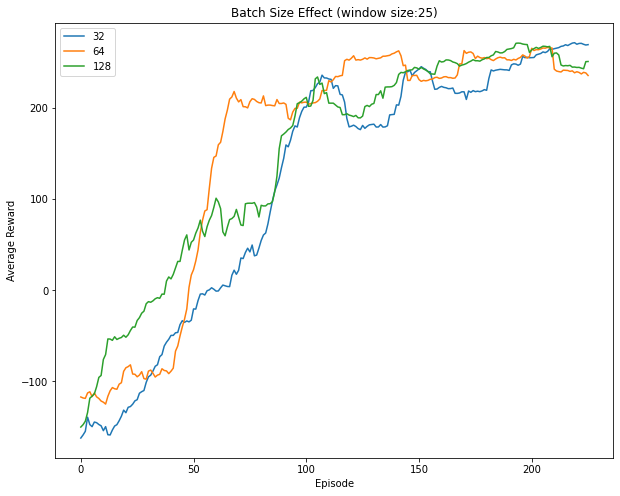

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 8))
plt.title("Batch Size Effect (window size:25)")
plt.plot(np.convolve(crs1, np.ones(25)/25, mode='valid'), label='32')
plt.plot(np.convolve(crs2, np.ones(25)/25, mode='valid'), label='64')
plt.plot(np.convolve(crs3, np.ones(25)/25, mode='valid'), label='128')
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.legend()

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class DDQNAgent():
    def __init__(self, state_size, action_size, batch_size,
                 gamma=0.99, buffer_size=25000, alpha=1e-4):
        self.state_size = state_size
        self.action_size = action_size

        # Hyperparameters
        self.batch_size = batch_size
        self.gamma = gamma

        # Experience Memory
        self.replay_buffer = ReplayBuffer(buffer_size)

        # Networks
        self.value_net = DeepQNetwork(state_size, action_size).to(device)
        self.target_value_net = DeepQNetwork(state_size, action_size).to(device)
        self.update_target_network()

        # Optimizer
        self.optimizer = optim.Adam(self.value_net.parameters(), lr=alpha)

    def take_action(self, state, eps=0.0):
        state = torch.from_numpy(state).float().to(device)
        # e-greedy
        if np.random.rand()>eps:
            with torch.no_grad():
                qs = self.value_net(state)
                return torch.argmax(qs).view(1, 1)
        else:
            return torch.tensor([[np.random.randint(self.action_size)]])

    def update_params(self):
        """
        Update networks weights
        """
        if len(self.replay_buffer) < self.batch_size:
            return
        batch = Transition(*zip(*self.replay_buffer.sample(self.batch_size)))

        state_batch = torch.from_numpy(np.vstack(batch.state)).float().to(device)
        action_batch = torch.tensor(np.vstack(batch.action)).long().to(device)
        next_state_batch = torch.from_numpy(np.vstack(batch.next_state)).float().to(device)
        reward_batch = torch.tensor(np.vstack(batch.reward)).float().to(device)
        done_batch = torch.tensor(np.vstack(batch.done)).to(device)

        # Compute Q(s_t, a)
        q_values = self.value_net(state_batch).gather(1, action_batch)

        # Compute the expected Q values
        next_q_values = self.target_value_net(next_state_batch).detach().max(1)[0].unsqueeze(1)
        next_q_values[done_batch] = 0.0
        expected_q_values = reward_batch + (self.gamma * next_q_values)

        # Compute loss
        loss = F.mse_loss(q_values, expected_q_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        for target_param, param in zip(self.target_value_net.parameters(), self.value_net.parameters()):
            target_param.data.copy_(param.data)
    
    def load(self, fname, device):
        self.value_net.load_state_dict(torch.load(fname, map_location=torch.device(device)))

In [ ]:
eps = 1.0
eps_decay_rate = 0.97
eps_end = 0.01

agent = DDQNAgent(state_size, action_size, batch_size=64)

crs4 = np.zeros(n_episodes)
crs_recent = deque(maxlen=25)
for i_episode in range(1, n_episodes+1):
    # Initialize the environment and state
    S = env.reset()
    done = False
    cr = 0
    n_step = 0
    while not done:
        # Select and perform an action
        A = agent.take_action(S, eps).item()
        Sp, R, done, _ = env.step(A)
        n_step = (n_step + 1) % 5

        agent.replay_buffer.store_trans(S, A, Sp, R, done)
        agent.update_params()
        if n_step == 0:
            agent.update_target_network()
        
        S = Sp
        cr += R
        if done:
            break
    
    eps = max(eps_end, eps_decay_rate*eps)

    crs4[i_episode-1]=cr
    crs_recent.append(cr)
    print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps), end="")
    if i_episode % 25 == 0:
        print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps))

torch.save(agent.value_net.state_dict(), 'ddqn64-checkpoint.pth')

Episode 25	Average Reward: -114.34	Epsilon: 0.47
Episode 50	Average Reward: -40.31	Epsilon: 0.22
Episode 75	Average Reward: 61.91	Epsilon: 0.10
Episode 100	Average Reward: 177.07	Epsilon: 0.05
Episode 125	Average Reward: 227.23	Epsilon: 0.02
Episode 150	Average Reward: 250.72	Epsilon: 0.01
Episode 175	Average Reward: 236.81	Epsilon: 0.01
Episode 200	Average Reward: 196.82	Epsilon: 0.01
Episode 225	Average Reward: 193.75	Epsilon: 0.01
Episode 250	Average Reward: 237.90	Epsilon: 0.01


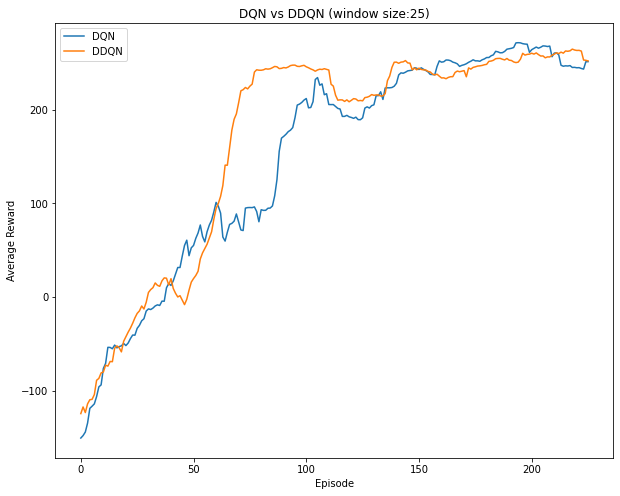

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 8))
plt.title("DQN vs DDQN (window size:25)")
plt.plot(np.convolve(crs2, np.ones(25)/25, mode='valid'), label='DQN')
plt.plot(np.convolve(crs4, np.ones(25)/25, mode='valid'), label='DDQN')
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.legend()

In [ ]:
import gym
from gym import wrappers

env = gym.make('LunarLander-v2')
env = wrappers.RecordVideo(env, 'output-address')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

agent = DQNAgent(state_size, action_size)
agent.load('checkpoint-address')

for _ in range(10):
    S = env.reset()
    done = False
    # cr = 0
    while(not done):
        # Select and perform an action
        A = agent.take_action(S).item()
        Sp, R, done, _ = env.step(A)

        S = Sp
        # cr += R

env.close()